In [1]:
import pandas as pd
from cartopy import crs as ccrs
import xarray as xr
from xhistogram.xarray import histogram
import numpy as np
# import gfdl_utils as gu
import glob
import re
from scipy.interpolate import griddata
import geopy
import cmocean.cm as cmo
import cmocean
import gsw
from geopy import distance
import xesmf as xe
# import sectionate
import sys
sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src')
from src import *
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook")
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150


In [9]:
# GLODAP:model variable naming conventions
model2glodap_names = {'cfc12':'cfc12','cfc11':'cfc11','sf6':'sf6','thetao':'theta','so':'salinity'}
variable_kwargs = {
    'cfc12':{'conversion':1e12/1035,'cmap':'Greens','units':'pmol kg-1'},
    'cfc11':{'conversion':1e12/1035,'cmap':cmo.matter_r,'units':r'pmol kg$^{-1}$'},
    'sf6':{'conversion':1e12/1035 * 1e3,'cmap':'Blues','units':'fmol kg-1'},
    'theta':{'conversion':1,'cmap':cmocean.cm.thermal,'units':'degK'},
    'thetao':{'conversion':1,'cmap':cmocean.cm.thermal,'units':'deg C'},
    'ct':{'conversion':1,'cmap':cmocean.cm.thermal,'units':'deg C'},
    'sa':{'conversion':1,'cmap':cmocean.cm.haline,'units':r'g kg$^{-1}$'},
    'so':{'conversion':1,'cmap':cmocean.cm.haline,'units':'psu'},
    'salinity':{'conversion':1,'cmap':cmocean.cm.haline,'units':'psu'}, 
    'density':{'conversion':1,'cmap':cmocean.cm.dense,'units':r'kg m$^{-3}$'},
    'rho2':{'conversion':1,'cmap':cmocean.cm.dense,'units':r'kg m$^{-3}$'},

    'agessc':{'conversion':1,'cmap':cmocean.cm.speed,'units':'years'}
}

In [10]:
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/" + x
ds = xr.open_dataset(datadir("SO_Tracer_Hov_on_Z.nc"))
ds = ds.rename({"z_l":"z"}).groupby("time.year").mean("time")

In [11]:
#define sigma levels
siglevels = np.arange(36.2, 37.4, .2) 
siglevels = 1.0 * np.sort(np.append(siglevels, [36.9, 37.11, 37.21, 37.22, 37.23, 37.24]))
siglevels

array([36.2 , 36.4 , 36.6 , 36.8 , 36.9 , 37.  , 37.11, 37.2 , 37.21,
       37.22, 37.23, 37.24])

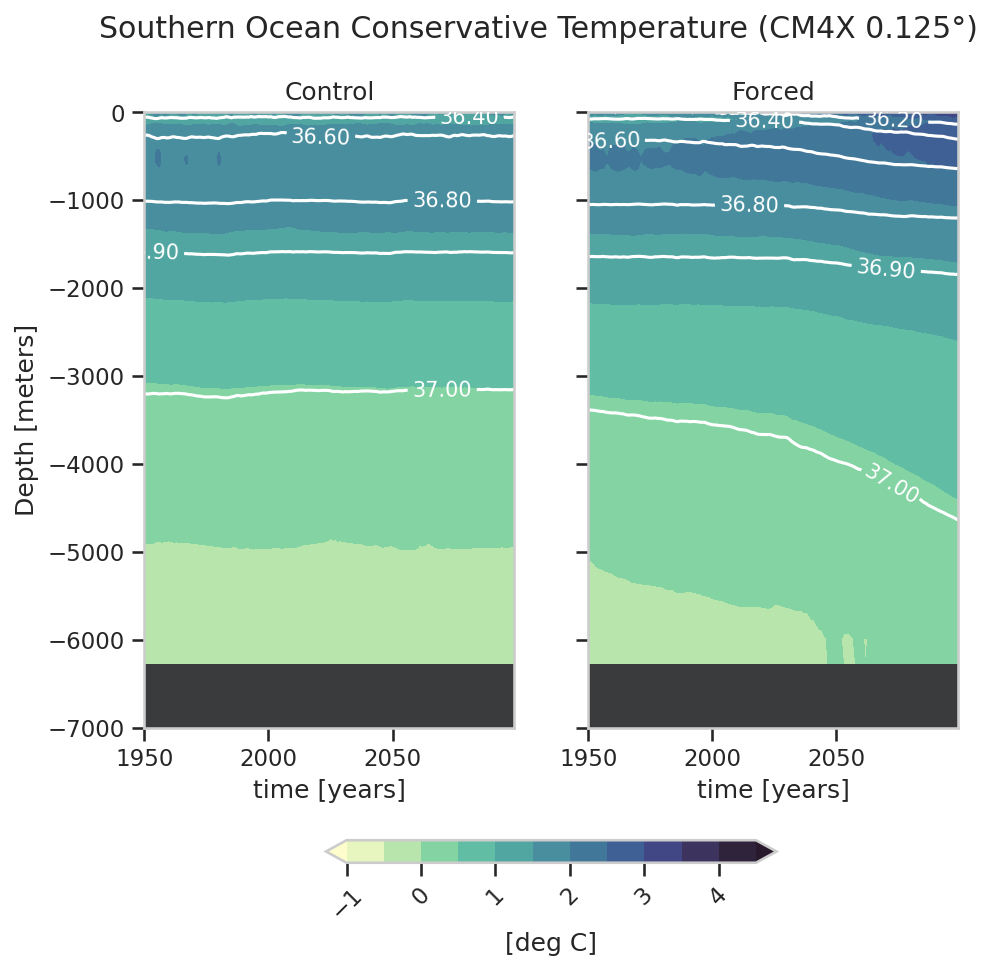

In [12]:
fig, ax = plt.subplots(1, 2, figsize = (7, 6.5), sharey = True)
levels = np.arange(-1, 5, 0.5)
tracer = "ct"; tracername = "Conservative Temperature"
fig.suptitle(f"Southern Ocean {tracername} (CM4X 0.125°)")

def plot_temperature(ds, ax, tracer, levels, siglevels): 
    tmp1 = ds[[tracer, "rho2"]]
    cntf = ax.contourf(tmp1.year, tmp1.z, tmp1[tracer].T, cmap = cmo.deep, extend = "both", levels = levels)
    cnt = ax.contour(tmp1.year, tmp1.z, tmp1.rho2.T, levels = siglevels, colors = "white");
    cs = ax.clabel(cnt, inline=True, fontsize=10)
    return cntf, cnt, cs

cntf, cnt, cs = plot_temperature(ds.sel(exp = "control"), ax[0], tracer, levels, siglevels)
ax[0].set_ylabel("Depth [meters]")
ax[0].set_xlabel("time [years]")
ax[0].set_title("Control")

cntf, cnt, cs = plot_temperature(ds.sel(exp = "forced"), ax[1], tracer, levels, siglevels)
# ax[1].set_yticklabels([])
ax[1].set_title("Forced")
ax[1].set_xlabel("time [years]")

[a.set_facecolor("#3A3B3C") for a in ax]
[a.grid(alpha = 0) for a in ax]
[a.set_ylim(-7000, -0) for a in ax]
[a.tick_params(bottom=True, left=True) for a in ax.flatten()];

cbar = fig.colorbar(cntf, ax = ax[0:2], label = f"[{variable_kwargs[tracer]["units"]}]", 
                    orientation = "horizontal", fraction = 0.03)
cbar.ax.tick_params(rotation=45)

# fig.savefig(plotsdir("paper_figures/SouthernOceanTemperature.png"), bbox_inches = "tight", dpi = 100)

<xarray.DataArray 'cfc11' ()> Size: 8B
array(3.21293785e-07)
Coordinates:
    exp      <U7 28B 'control'
<xarray.DataArray 'cfc11' ()> Size: 8B
array(4.10892445e-08)
Coordinates:
    exp      <U7 28B 'forced'


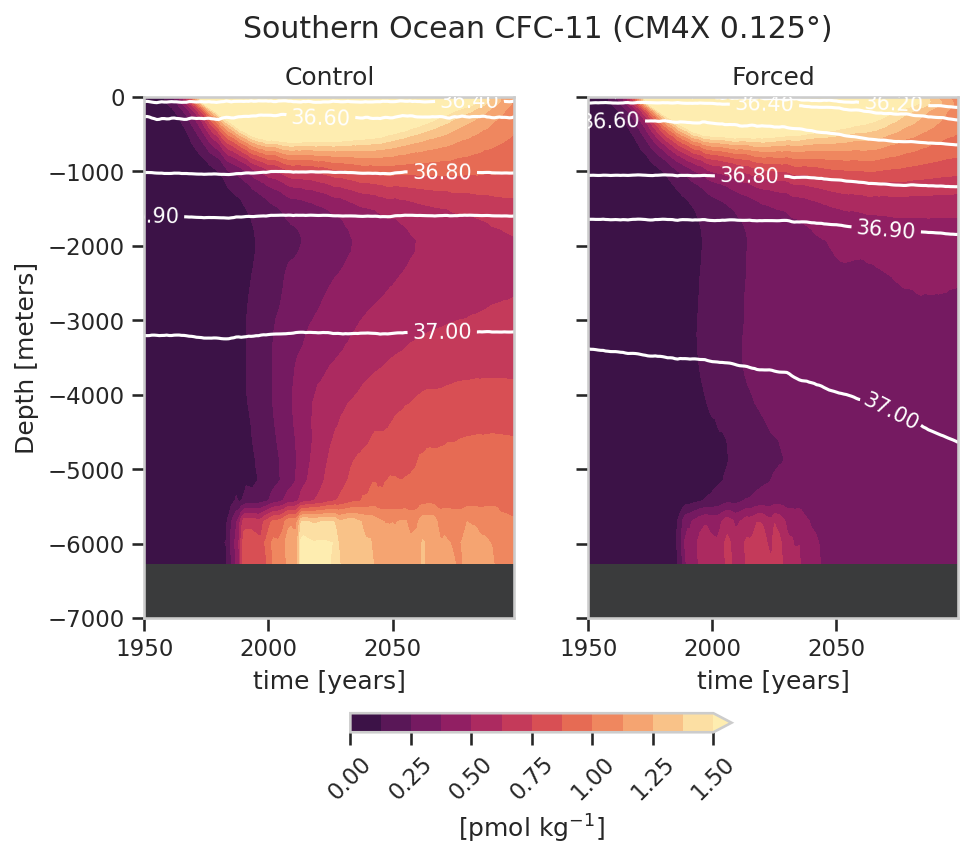

In [13]:
fig, ax = plt.subplots(1, 2, figsize = (7, 5.5), sharey = True)
levels = np.arange(0, 1.51, 0.125)
tracer = "cfc11"; tracername = "CFC-11"
fig.suptitle(f"Southern Ocean {tracername} (CM4X 0.125°)")

def plot_tracer(ds, ax, tracer, levels, siglevels): 
    tmp1 = ds[[tracer, "rho2"]]
    tmp1[tracer] = tmp1[tracer] * variable_kwargs[tracer]["conversion"]
    print(tmp1[tracer].min())
    tmp1[tracer] = tmp1[tracer].where(tmp1[tracer] >= 0)
    cntf = ax.contourf(tmp1.year, tmp1.z, tmp1[tracer].T, cmap = cmo.matter_r, extend = "max", levels = levels)
    # cntf = ax.pcolormesh(tmp1.year, tmp1.z, tmp1[tracer].T, cmap = cmo.matter_r,vmin = 0, vmax = 1.51)

    cnt = ax.contour(tmp1.year, tmp1.z, tmp1.rho2.T, levels = siglevels, colors = "white");
    cs = ax.clabel(cnt, inline=True, fontsize=10)
    return cntf, cnt, cs

cntf, cnt, cs = plot_tracer(ds.sel(exp = "control"), ax[0], tracer, levels, siglevels)
ax[0].set_ylabel("Depth [meters]")
ax[0].set_xlabel("time [years]")
ax[0].set_title("Control")

cntf, cnt, cs = plot_tracer(ds.sel(exp = "forced"), ax[1], tracer, levels, siglevels)
# ax[1].set_yticklabels([])
ax[1].set_title("Forced")
ax[1].set_xlabel("time [years]")

[a.set_facecolor("#3A3B3C") for a in ax]
[a.grid(alpha = 0) for a in ax]
[a.set_ylim(-7000, -0) for a in ax]
[a.tick_params(bottom=True, left=True) for a in ax.flatten()];

cbar = fig.colorbar(cntf, ax = ax[0:2], label = f"[{variable_kwargs[tracer]["units"]}]", 
                    orientation = "horizontal", fraction = 0.03)
cbar.ax.tick_params(rotation=45)
# fig.savefig(plotsdir("paper_figures/SouthernOceanCFC11.png"), bbox_inches = "tight", dpi = 100)

<xarray.DataArray 'cfc12' ()> Size: 8B
array(1.41883653e-05)
Coordinates:
    exp      <U7 28B 'control'
<xarray.DataArray 'cfc12' ()> Size: 8B
array(2.83995503e-05)
Coordinates:
    exp      <U7 28B 'forced'


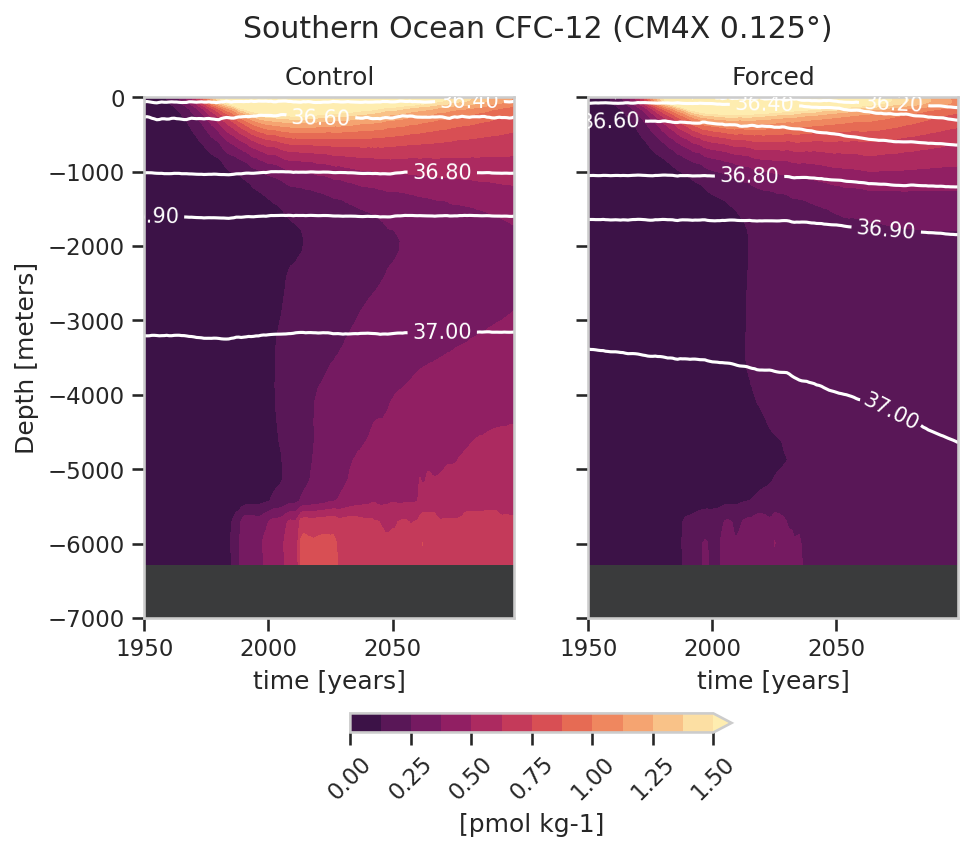

In [14]:
fig, ax = plt.subplots(1, 2, figsize = (7, 5.5), sharey = True)
levels = np.arange(0, 1.51, 0.125)
tracer = "cfc12"; tracername = "CFC-12"
fig.suptitle(f"Southern Ocean {tracername} (CM4X 0.125°)")

def plot_tracer(ds, ax, tracer, levels, siglevels): 
    tmp1 = ds[[tracer, "rho2"]]
    tmp1[tracer] = tmp1[tracer] * variable_kwargs[tracer]["conversion"]
    print(tmp1[tracer].min())
    tmp1[tracer] = tmp1[tracer].where(tmp1[tracer] >= 0)
    cntf = ax.contourf(tmp1.year, tmp1.z, tmp1[tracer].T, cmap = cmo.matter_r, extend = "max", levels = levels)
    cnt = ax.contour(tmp1.year, tmp1.z, tmp1.rho2.T, levels = siglevels, colors = "white");
    cs = ax.clabel(cnt, inline=True, fontsize=10)
    return cntf, cnt, cs

cntf, cnt, cs = plot_tracer(ds.sel(exp = "control"), ax[0], tracer, levels, siglevels)
ax[0].set_ylabel("Depth [meters]")
ax[0].set_xlabel("time [years]")
ax[0].set_title("Control")

cntf, cnt, cs = plot_tracer(ds.sel(exp = "forced"), ax[1], tracer, levels, siglevels)
# ax[1].set_yticklabels([])
ax[1].set_title("Forced")
ax[1].set_xlabel("time [years]")

[a.set_facecolor("#3A3B3C") for a in ax]
[a.grid(alpha = 0) for a in ax]
[a.set_ylim(-7000, -0) for a in ax]
[a.tick_params(bottom=True, left=True) for a in ax.flatten()];

cbar = fig.colorbar(cntf, ax = ax[0:2], label = f"[{variable_kwargs[tracer]["units"]}]", 
                    orientation = "horizontal", fraction = 0.03)
cbar.ax.tick_params(rotation=45)
# fig.savefig(plotsdir("paper_figures/SouthernOceanCFC11.png"), bbox_inches = "tight", dpi = 100)